In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seven_stations import calc_seven_stations
from graph_denoising import graph_denoising, graph_measures
np.set_printoptions(precision=2)
%matplotlib inline  


def normalisation(all_data):
    # all_data[all_data == 0] = np.nan
    # all_data_one_by_r = 1/all_data
    all_data_one_by_r = all_data
    #print(all_data_one_by_r)
    minimum = np.nanmin(all_data_one_by_r)
    #print(minimum)
    maximum = np.nanmax(all_data_one_by_r)
    #print(maximum)
    normalized_zero_to_one = (all_data_one_by_r - minimum) / (maximum - minimum)
    #print(normalized_zero_to_one)
    normalized_zero_to_one = np.nan_to_num(normalized_zero_to_one, 0)
    return normalized_zero_to_one, minimum, maximum

def reverse_normalisation(all_results, minimum, maximum):
    # all_results = np.array(all_results, dtype=np.float32)
    all_data_one_by_r = all_results * (maximum - minimum) + minimum
    #print(all_data_one_by_r)
    # all_data_one_by_r[all_data_one_by_r == 0] = np.nan
    #print(all_data_one_by_r)
    # all_data = 1/all_data_one_by_r
    all_data = all_data_one_by_r
    #print(all_data)
    all_data = np.nan_to_num(all_data, 0)
    return all_data
    

In [125]:
a, mi, ma = normalisation(np.array([1.,2.,3.]))
np.nanmax(1/THE_array)

190021.68207868215

The algorithm stopped because of reaching max iterations. Error at the end was 12.18229384050047.
The algorithm stopped because of reaching max iterations. Error at the end was 12.28792079832545.
The algorithm stopped because of reaching max iterations. Error at the end was 12.394817089372667.


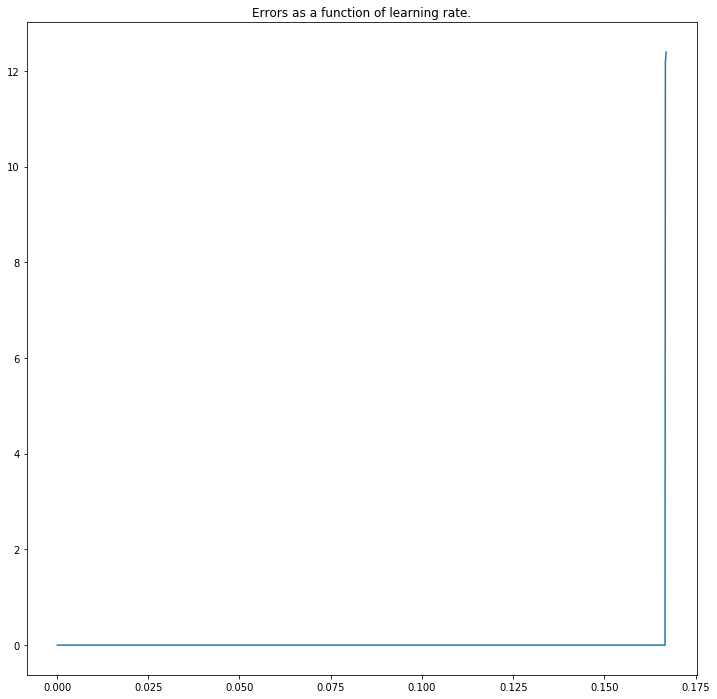

In [126]:

    
#_____________________________________________________________________________________________________________________#
#determinig the W_d.
filename_info = 'C:/MyTemp/ECMI_Data/dt/AlpArray/METRICS/2016366_local_pair_dist.txt'

distances = np.zeros((7,7))
# print(distances)
file = open(filename_info)
names = ["FR.CALF.00.HHZ",
         "FR.EILF.00.HHZ",
         "FR.ESCA.01.HHZ",
         "FR.MON.00.HHZ",
         "FR.MVIF.00.HHZ",
         "FR.PRIMA.00.HHZ",
         "FR.SAOF.00.HHZ"]
i = 0
for line in file:
    line_split = line.split(" ")
    if line_split[0] in names and line_split[1] in names:
        distances[names.index(line_split[0]), names.index(line_split[1])] = line_split[2]
        distances[names.index(line_split[1]), names.index(line_split[0])] = line_split[2]
        i = i+1
file.close()
# print(distances)

for i in range(7):
    distances[i,i] = np.nan
W_d = normalisation(distances)[0]

#_________________________________________________________________________________________________________________________# 
#read W_t

array, minimum, maximum = normalisation(np.array(calc_seven_stations("C:/MyTemp/"))[:,3216])
result = np.zeros((7,7))

i = 0
j = 0
for t in range(len(array)):
    if j == i:
        j = j + 1
    #print("t= " + str(t))
    #print(array[t])
    result[i, j] = array[t]
    result[j, i] = array[t]
    # print(t)
    #print("i = " + str(i))
    #print("j = " + str(j))
    if j < 6:
        j = j + 1
    else:
        j = i + 1
        i = i + 1
W_t = result

#____________________________________________________________________________________________________________________#

estimates = graph_measures(W_d) #estimates
epsilon = 0.001 # This should be quite small

learning_rates = [0.0001*i for i in range(1,1670)]
results = [graph_denoising(W_t, estimates, epsilon, learning_rate=i, max_iterations=100000)for i in learning_rates] # ready to run when we get the matrices.
results_W = np.array([results[i][0] for i in range(0,1669)])
results_t = np.array([results[i][1] for i in range(0,1669)])
results_E = np.array([results[i][2] for i in range(0,1669)])

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_E)
plt.title("Errors as a function of learning rate.")
plt.show()


In [127]:
results_E

array([1.00e-03, 9.99e-04, 9.99e-04, ..., 1.22e+01, 1.23e+01, 1.24e+01])

In [128]:
learning_rate = learning_rates[np.argmin(results_E)]
learning_rate

0.1203

In [129]:
THE_array = np.array(calc_seven_stations("C:/MyTemp/"))

In [130]:
def do_a_timeseries(dt_data, estimates, epsilon, learning_rate, max_iterations):
    W_t_arrays = np.array([make_Wt(dt_data[:,i]) for i in range(len(dt_data[0]))])
    ret = [graph_denoising(W_t, estimates, epsilon, learning_rate, max_iterations) for W_t in W_t_arrays] # ready to run when we get the matrices.
    return np.array(ret)
normalized_array, minimum, maximum = normalisation(THE_array)
W_t_arrays = np.array([make_Wt(normalized_array[:,i]) for i in range(len(normalized_array[0]))])
timeseries = do_a_timeseries(normalized_array, estimates, 0.001, learning_rate, 1000000)

In [131]:
asdd = np.array(list(timeseries[:,0]), dtype=np.float32)
asd = reverse_normalisation(asdd, minimum, maximum)
print(np.nanmin(THE_array))
print(np.nanmax(THE_array))
print(np.min(normalized_array))
print(np.max(normalized_array))
print(np.min(asdd))
print(np.max(asdd))
print(np.min(asd))
np.max(asd)

-3.3332419395446777
3.3331305980682373
0.0
1.0
0.0
1.0
-3.333242


3.3331304

In [133]:
reversed_W_ts = reverse_normalisation(W_t_arrays, minimum, maximum)
np.max(asd - reversed_W_ts)

4.6400580406188965

In [6]:
def figure_out_the_size(integer):
    ret = 1
    summa = 1
    t = 2
    while integer != summa  and t != 100:
        # print(summa)
        summa = summa + t
        t = t + 1
    ret = t
    return ret
figure_out_the_size(21)

    

7

In [81]:
def make_Wt(array):
    size = figure_out_the_size(len(array))
    result = np.zeros((size,size))
    #result[0, 1:7] = array[0:6]
    #result[1, 0:1] = array[6]
    #result[1, 2:7] = array[7:11]
    #result[2, 0:2] = array[11:13]
    #result[2, 3:7] = array[13:16]
    i = 0
    j = 0
    for t in range(len(array)):
        if j == i:
            j = j + 1
        #print("t= " + str(t))
        #print(array[t])
        # print(i)
        # print(j)
        # print(result[i, j])
        # print(array[t])
        result[i, j] = array[t]
        result[j, i] = array[t]
        # print(t)
        #print("i = " + str(i))
        #print("j = " + str(j))
        if j < size-1:
            j = j + 1
        else:
            j = i + 1
            i = i + 1
    return result

make_Wt(array) == W_t


array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

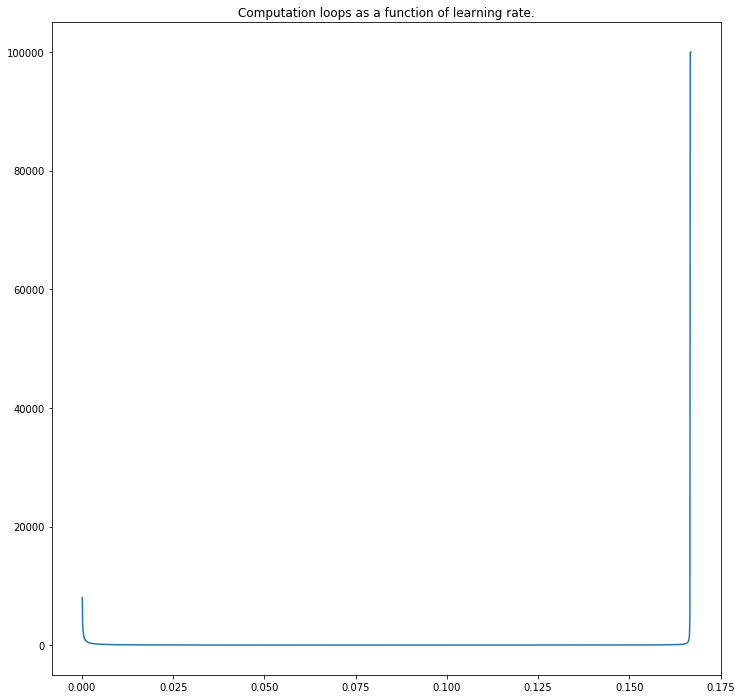

In [134]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_t)
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


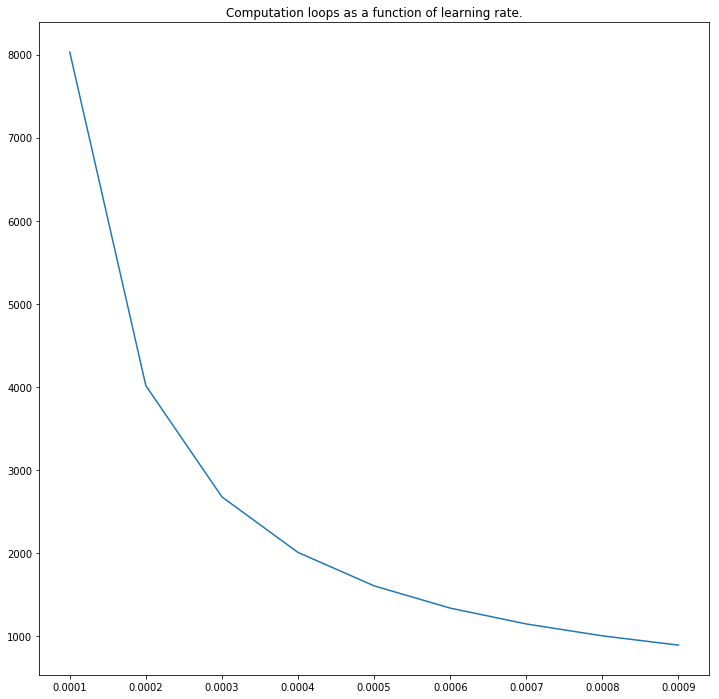

In [135]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates[0:9], results_t[0:9])
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


In [136]:
results_W[np.argmin(results_E)] #Denoised

array([[0.  , 0.93, 0.16, 0.4 , 0.52, 0.44, 0.52],
       [0.93, 0.  , 0.04, 0.3 , 0.67, 0.03, 0.86],
       [0.16, 0.04, 0.  , 0.56, 0.03, 0.09, 0.82],
       [0.4 , 0.3 , 0.56, 0.  , 0.07, 0.23, 0.33],
       [0.52, 0.67, 0.03, 0.07, 0.  , 0.32, 0.5 ],
       [0.44, 0.03, 0.09, 0.23, 0.32, 0.  , 0.7 ],
       [0.52, 0.86, 0.82, 0.33, 0.5 , 0.7 , 0.  ]])

In [137]:
W_t #Noisy one

array([[0.  , 1.  , 0.54, 0.5 , 0.81, 0.78, 0.57],
       [1.  , 0.  , 0.13, 0.15, 0.71, 0.  , 0.65],
       [0.54, 0.13, 0.  , 0.71, 0.37, 0.48, 0.92],
       [0.5 , 0.15, 0.71, 0.  , 0.14, 0.35, 0.16],
       [0.81, 0.71, 0.37, 0.14, 0.  , 0.63, 0.52],
       [0.78, 0.  , 0.48, 0.35, 0.63, 0.  , 0.77],
       [0.57, 0.65, 0.92, 0.16, 0.52, 0.77, 0.  ]])

In [138]:
np.argmin(results_E)

1202

In [139]:
the_smallest_error_so_far = results_E[np.argmin(results_E)]

In [140]:
if the_smallest_error_so_far >= np.min(results_E):
    the_best_learning_rate_so_far = learning_rates[np.argmin(results_E)]
    the_smallest_error_so_far = np.min(results_E)

In [141]:
the_smallest_error_so_far

0.00018693534636841257

In [142]:
the_best_learning_rate_so_far

0.1203

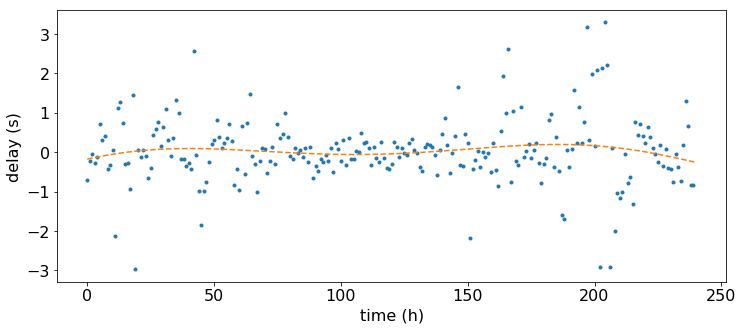

In [220]:
z = np.polyfit(range(240), reversed_W_ts[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240:,1,0])), reversed_W_ts[0:240,1,0], ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Noisy time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


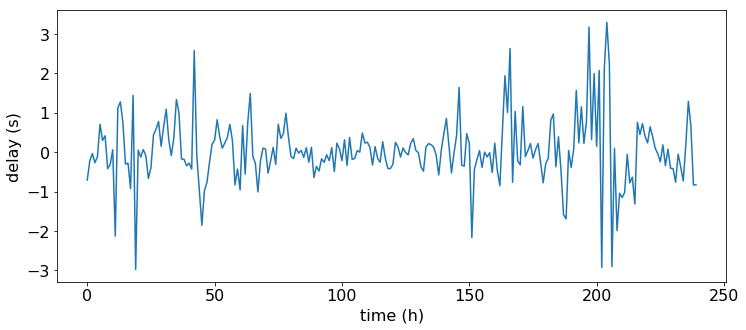

In [221]:
z = np.polyfit(range(240), reversed_W_ts[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240:,1,0])), reversed_W_ts[0:240,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Noisy time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


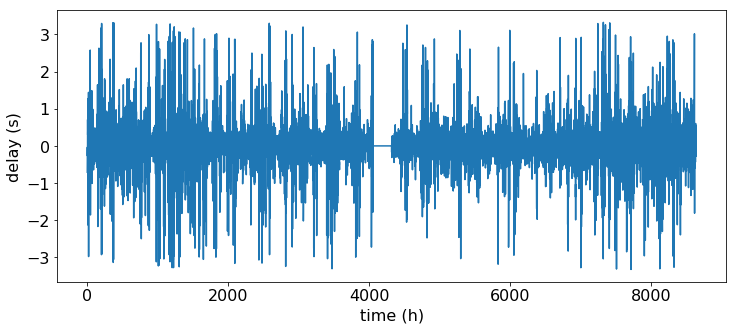

In [222]:
z = np.polyfit(range(240), reversed_W_ts[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[:,1,0])), reversed_W_ts[:,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Noisy time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

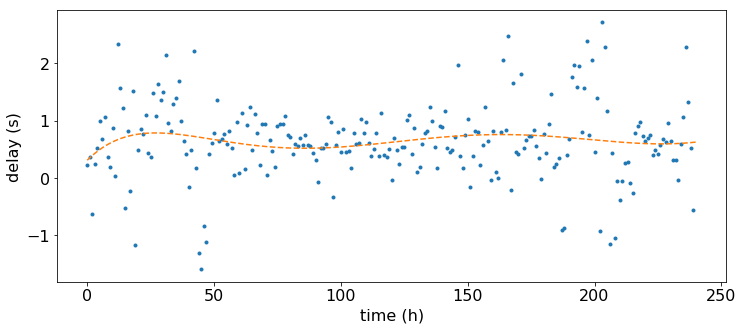

In [217]:
z = np.polyfit(range(240), asd[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)


width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240,1,0])), asd[0:240,1,0], ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Denoised time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


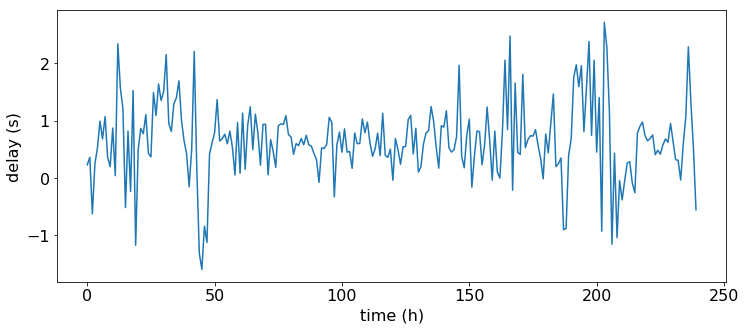

In [223]:
z = np.polyfit(range(240), asd[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)


width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240,1,0])), asd[0:240,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Denoised time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

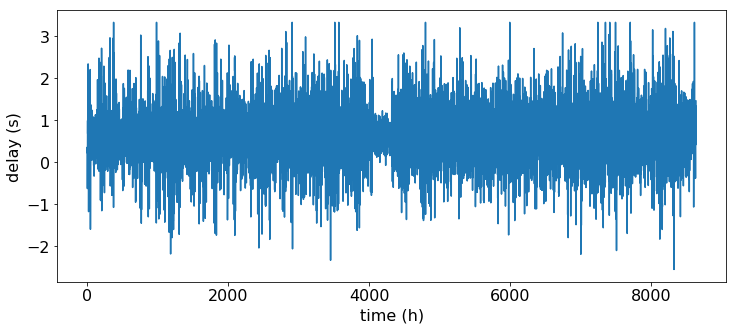

In [224]:
z = np.polyfit(range(240), asd[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)


width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[:,1,0])), asd[:,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Denoised time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

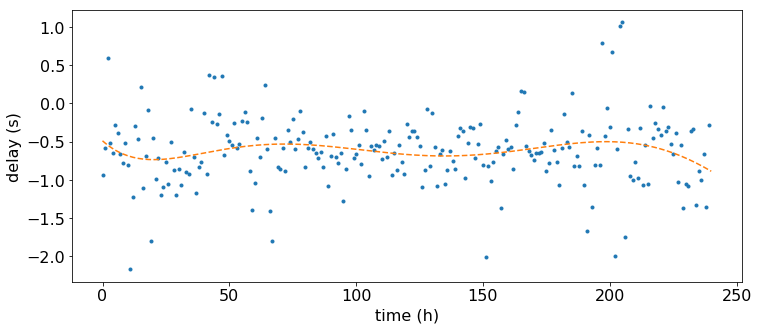

In [213]:
noise = reversed_W_ts[:,1,0] - asd[:,1,0]

z = np.polyfit(range(240), noise[0:240], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(noise[0:240])), noise[0:240], ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


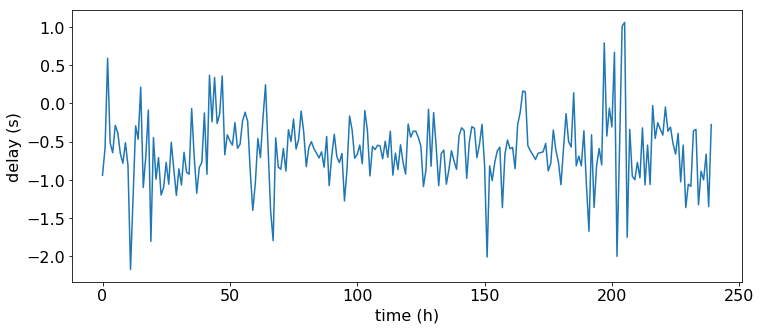

In [214]:
noise = reversed_W_ts[:,1,0] - asd[:,1,0]

z = np.polyfit(range(240), noise[0:240], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(noise[0:240])), noise[0:240])#,".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

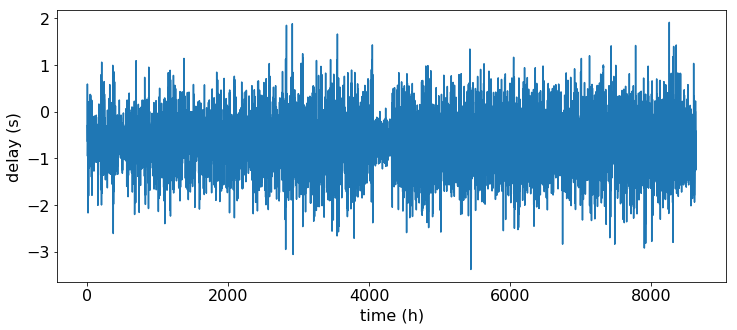

In [215]:
noise = reversed_W_ts[:,1,0] - asd[:,1,0]

z = np.polyfit(range(240), noise[0:240], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(noise)), noise)#,".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

In [190]:
print(xp)

[  0.     1.     2.01   3.01   4.02   5.02   6.03   7.03   8.03   9.04
  10.04  11.05  12.05  13.05  14.06  15.06  16.07  17.07  18.08  19.08
  20.08  21.09  22.09  23.1   24.1   25.1   26.11  27.11  28.12  29.12
  30.13  31.13  32.13  33.14  34.14  35.15  36.15  37.15  38.16  39.16
  40.17  41.17  42.18  43.18  44.18  45.19  46.19  47.2   48.2   49.21
  50.21  51.21  52.22  53.22  54.23  55.23  56.23  57.24  58.24  59.25
  60.25  61.26  62.26  63.26  64.27  65.27  66.28  67.28  68.28  69.29
  70.29  71.3   72.3   73.31  74.31  75.31  76.32  77.32  78.33  79.33
  80.33  81.34  82.34  83.35  84.35  85.36  86.36  87.36  88.37  89.37
  90.38  91.38  92.38  93.39  94.39  95.4   96.4   97.41  98.41  99.41
 100.42 101.42 102.43 103.43 104.44 105.44 106.44 107.45 108.45 109.46
 110.46 111.46 112.47 113.47 114.48 115.48 116.49 117.49 118.49 119.5
 120.5  121.51 122.51 123.51 124.52 125.52 126.53 127.53 128.54 129.54
 130.54 131.55 132.55 133.56 134.56 135.56 136.57 137.57 138.58 139.58
 140.59

In [93]:
range(len(asd[:,1,0]))

range(0, 8640)

In [49]:
make_Wt(np.array(list(THE_array[:,4]), dtype=np.float32))

0
1
0.0
-0.11680899
0
2
0.0
-0.0029031737
0
3
0.0
nan
0
4
0.0
0.35437122
0
5
0.0
nan
0
6
0.0
-0.32249328
1
2
0.0
0.27415112
1
3
0.0
nan
1
4
0.0
-0.16098693
1
5
0.0
nan
1
6
0.0
-0.27722245
2
3
0.0
nan
2
4
0.0
-0.72159433
2
5
0.0
nan
2
6
0.0
-0.5844395
3
4
0.0
nan
3
5
0.0
nan
3
6
0.0
nan
4
5
0.0
nan
4
6
0.0
0.9994067
5
6
0.0
nan


array([[ 0.  , -0.12, -0.  ,   nan,  0.35,   nan, -0.32],
       [-0.12,  0.  ,  0.27,   nan, -0.16,   nan, -0.28],
       [-0.  ,  0.27,  0.  ,   nan, -0.72,   nan, -0.58],
       [  nan,   nan,   nan,  0.  ,   nan,   nan,   nan],
       [ 0.35, -0.16, -0.72,   nan,  0.  ,   nan,  1.  ],
       [  nan,   nan,   nan,   nan,   nan,  0.  ,   nan],
       [-0.32, -0.28, -0.58,   nan,  1.  ,   nan,  0.  ]])

In [41]:
np.shape(list(normalized_array[:,0]))

(21,)

In [50]:
print(minimum)

-70903.9841733921


In [51]:
print(maximum)

190021.68207868215


In [77]:
normalized_array, minimum, maximum = normalisation(THE_array)

In [78]:
minimum

-3.3332419395446777

In [79]:
maximum

3.3331305980682373

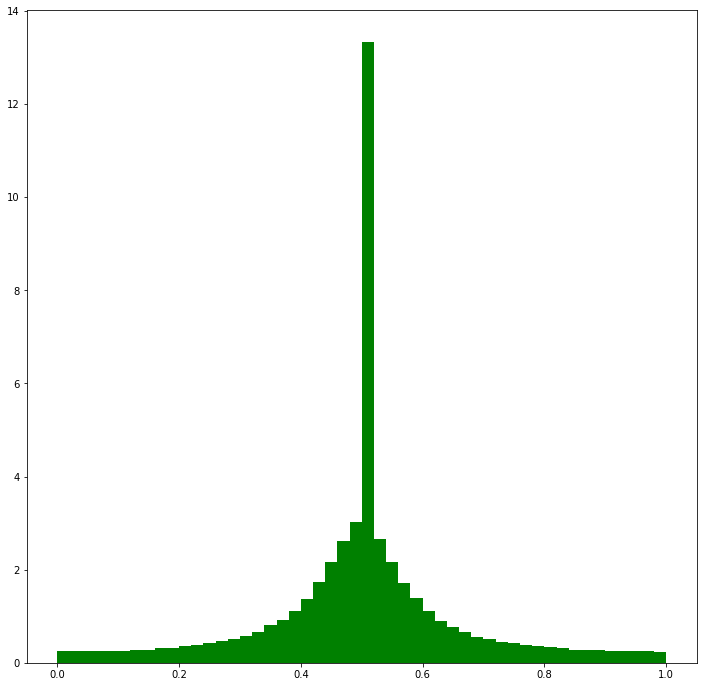

In [132]:
width = 12
height = 12
plt.figure(figsize=(width, height))
n, bins, patches = plt.hist(normalized_array.flatten(), 50, density=True, facecolor='green')
plt.show()

In [225]:
def make_connections_matrix(size):
    [(i, j) for j in range(size) for i in range(size)]
    def construct_the_line(index, size):
        ret = np.zeros(size)
        
    for i in range(size):
        number_of_connections = figure_out_the_size(size)
        construct_the_line(i, size)

In [226]:
figure_out_the_size(21)

7

In [310]:
def connections(number):
    retval = 0
    number = number - 1
    while number >= 0:
        retval = number + retval
        number = number - 1
    return retval
def make_connections_matrix(nodes):
    shape = (connections(nodes), nodes)
    #shape = (21, 7)
    t = shape[1] - 1
    result = np.zeros(shape)
    loop = 1
    line = 0
    for i in range(shape[0]):
        # print(i)
        for j in range(t):
            result[line, j + loop] = -1
            line = line+1

        t = t - 1
        loop = loop + 1
    #print(result)
    row = 0
    counter = 0
    where_to_count = shape[1] - 1
    for line in range(shape[0]):
        result[line, row] = 1
        counter = counter + 1 
        if counter >= where_to_count:
            counter = 0
            row = row + 1
            where_to_count = where_to_count - 1
    return result    

In [311]:
connections_matrix = make_connections_matrix(7)

array([[ 1., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1.]])

In [312]:
def tihonov_matrix(alfa, size):
    return(alfa * np.identity(size))

tihonov_matrix(2,3)

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [322]:
timeseries_matrices = np.array(list(timeseries[:,0]), dtype=np.float32)


In [348]:
def make_timeseries_vector(matrix):
    ret = []
    #print(matrix)
    for i in range(np.shape(matrix)[0]):
        for j in range(np.shape(matrix)[1]):
            if i < j:
                ret.append(matrix[i,j])
    return np.array(ret)

In [351]:
test = timeseries_matrices[0]
test2 = np.array([make_timeseries_vector(timeseries_matrices[i]) for i in range(len(timeseries_matrices))])
test2[1]

array([0.55, 0.45, 0.37, 0.4 , 0.36, 0.85, 0.39, 0.41, 0.49, 0.39, 0.62,
       0.17, 0.08, 0.16, 0.46, 0.22, 0.18, 0.55, 0.21, 0.74, 0.53],
      dtype=float32)